In [1]:
import aiohttp
import random
import sys
from PIL import Image
from matplotlib import cm
import numpy as np

sys.path.append('..')

from comfy_script.runtime.real import Workflow, load as load_comfy
from comfy_script.client import Client

In [2]:
comfy_url = 'http://34.84.71.113:8188'
client = Client(comfy_url, session_factory=lambda: aiohttp.ClientSession(auth=aiohttp.BasicAuth('wunderbar', 'qfA=!-gyWw$8Pk[')))

In [4]:
load_comfy(comfy_url)

In [5]:
import torch
from pathlib import Path
from comfy_script.runtime.real.nodes import (
    CheckpointLoaderSimple, 
    EmptyLatentImage, 
    KSampler, 
    VAEDecode, 
    CLIPTextEncode, 
    SaveImage,
    PreviewImage,
    LoadImage,
    ImageToMask,
    InvertMaskSegmentAnything,
    JWImageResizeByLongerSide,
    MaskPreview,
    Checkpoints,
    MaskToImageMtb,
    GrayscaleImageWLSH,
    ImageBlendingMode,
    ImageCompositeMasked,
)

In [6]:

def load_constrained_image(image_path, max_dimension=1024):
    image, _ = LoadImage(image_path)
    image = JWImageResizeByLongerSide(image, max_dimension, 'bicubic')
    return image
    
def load_mask_from_image(image, channel='red'):
    mask = ImageToMask(image, 'red')
    inverted_mask = InvertMaskSegmentAnything(mask)
    return mask, inverted_mask

def preview_image(result):
    image_previews = []
    for ui_image in result['ui']['images']:
        path = f"../{ui_image['type']}/{ui_image['filename']}"
        image = Image.open(path)
        image_previews.append((image, path))
    return image_previews

def grayscale_image(image):
    grayscale_image = GrayscaleImageWLSH(image)
    return grayscale_image

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    
    return grid

In [7]:
positive = 'beautiful scenery nature glass bottle landscape, , purple galaxy bottle,'
negative = 'text, watermark'
image_height = 1024 * 3
image_width = 1024 * 3
model_name = 'Realistic_Vision_V6.0_NV_B1.safetensors'
scheduler = 'karras'
sampler_name = 'euler'
base_image_filename = Path("talent_miki_fujimoto_0421_wunderbar_0870.jpg")
base_image_stem = base_image_filename.stem
seed = random.randint(1, 2**32)
steps = 20
cfg = 8
max_dimension = 512

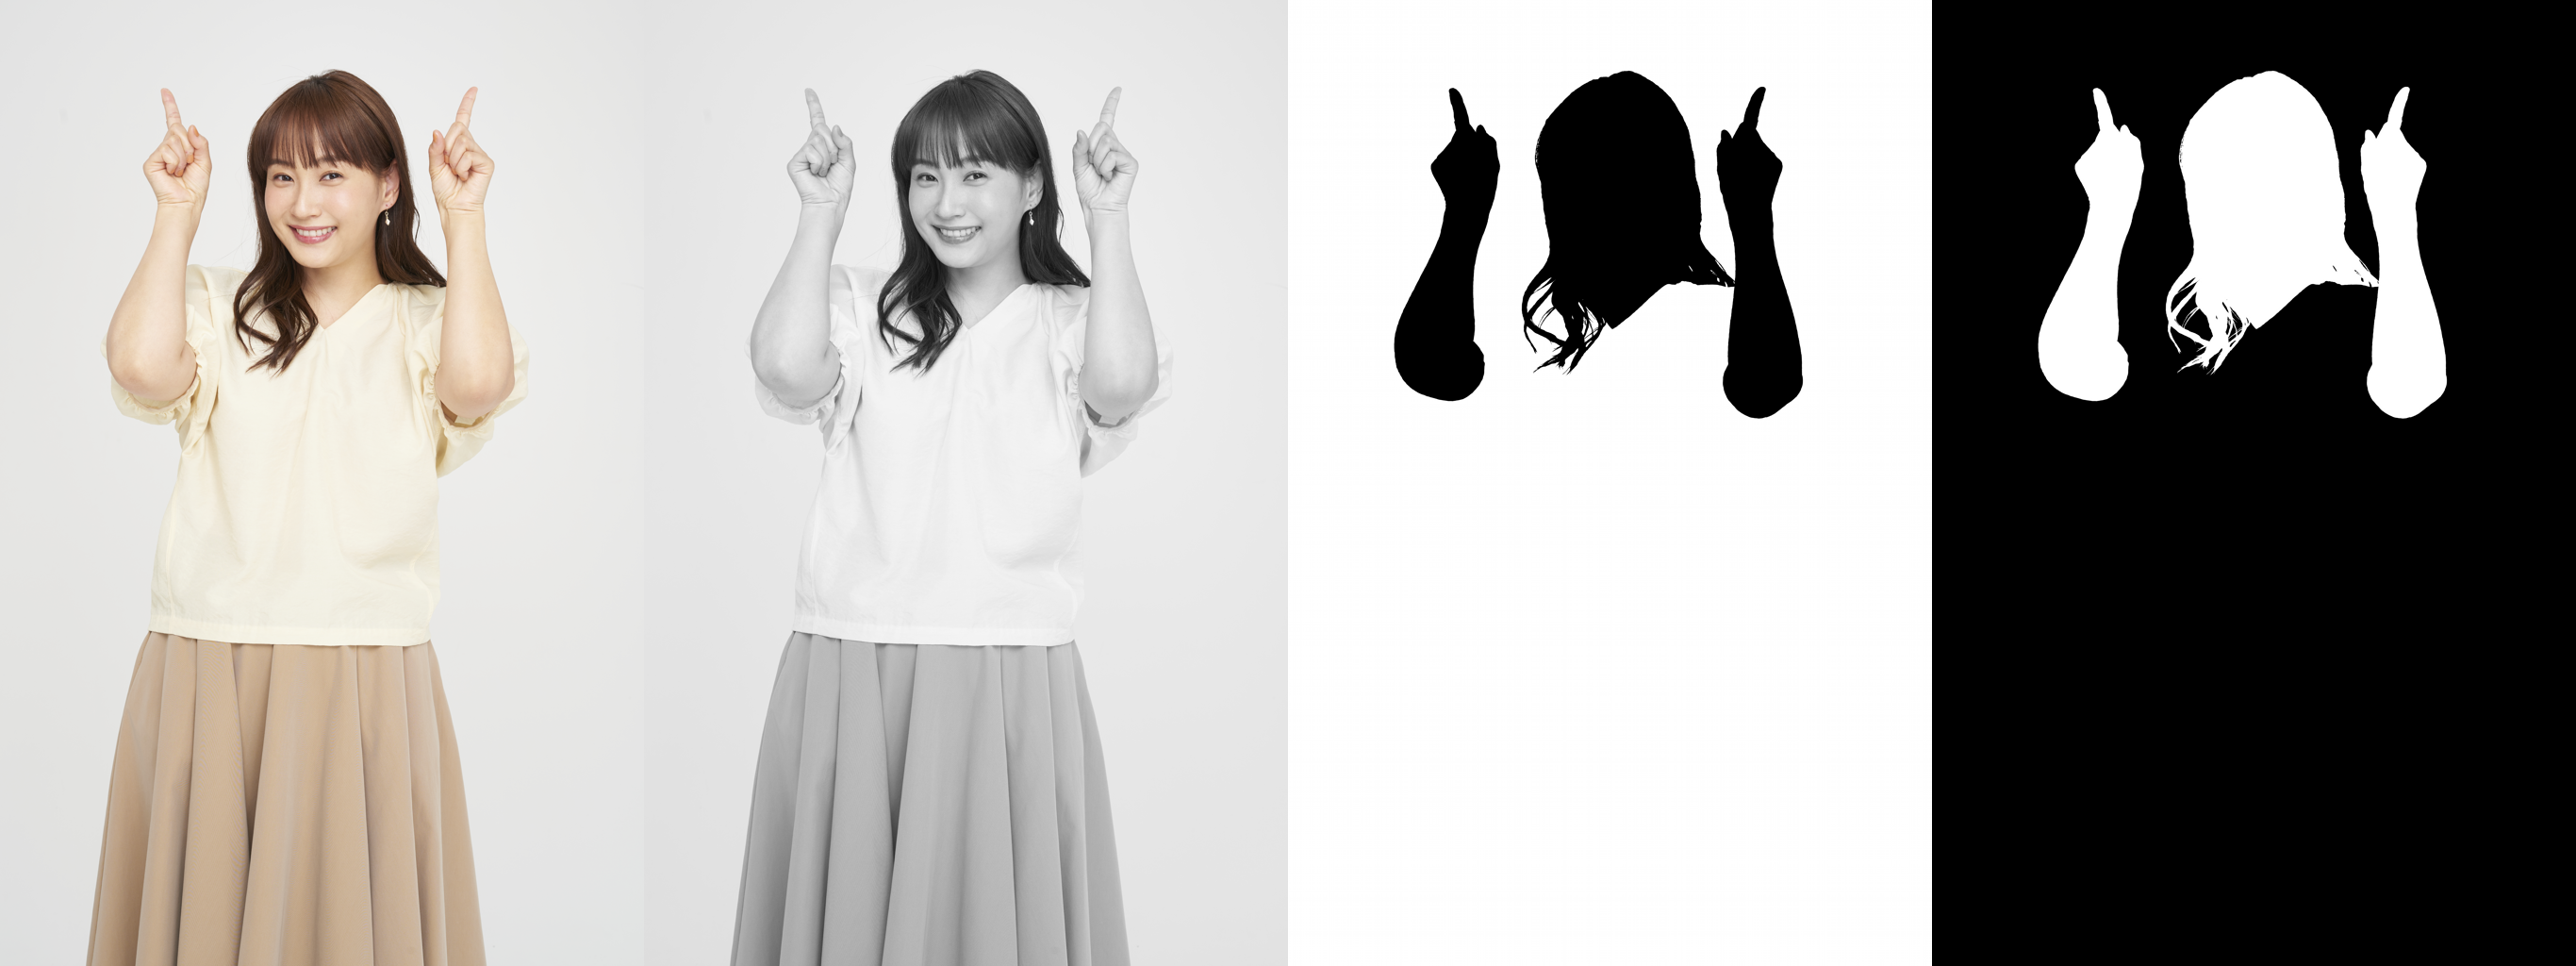

In [26]:
base_image = load_constrained_image(f"{base_image_filename}")
base_image_grayscale = grayscale_image(base_image)

# generate previews
base_image_preview, _ = preview_image(PreviewImage(base_image))[0]
base_image_grayscale_preview, _ = preview_image(PreviewImage(base_image_grayscale))[0]

# load masks
skin_mask_image = load_constrained_image(f"{base_image_stem}_skin_mask.jpg")
skin_mask, skin_mask_inverted = load_mask_from_image(skin_mask_image)
skin_mask_image_preview, _ = preview_image(MaskPreview(skin_mask))[0]
skin_mask_inverted_image_preview, _ = preview_image(MaskPreview(skin_mask_inverted))[0]

image_grid([base_image_preview, base_image_grayscale_preview, skin_mask_image_preview, skin_mask_inverted_image_preview], 1, 4)

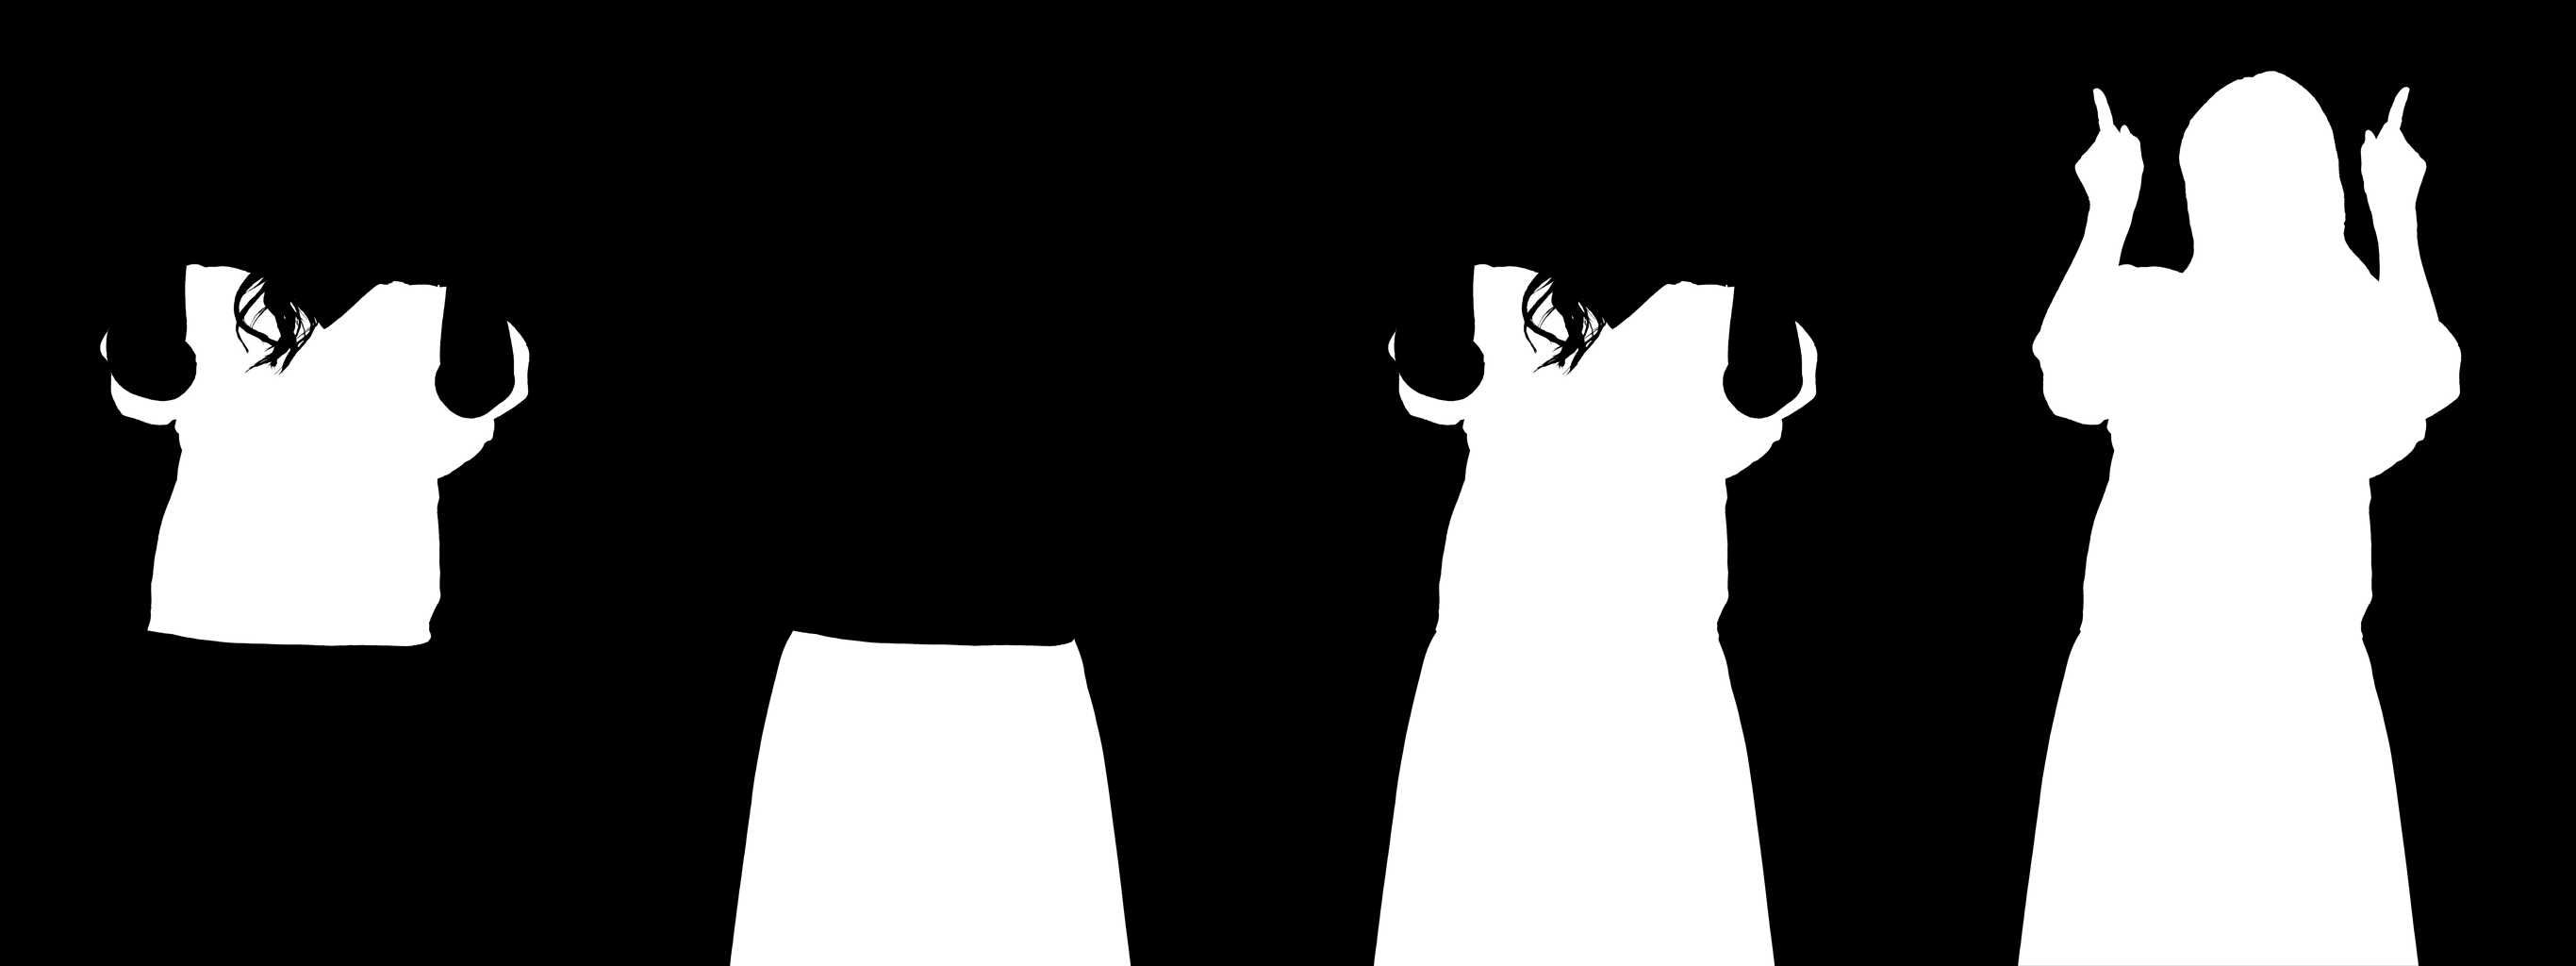

In [27]:
top_mask_image = load_constrained_image(f"{base_image_stem}_top_mask.jpg")
top_mask, top_mask_inverted = load_mask_from_image(top_mask_image)
top_mask_inverted_preview, _ = preview_image(MaskPreview(top_mask_inverted))[0]

bottom_mask_image = load_constrained_image(f"{base_image_stem}_bottom_mask.jpg")
bottom_mask, bottom_mask_inverted = load_mask_from_image(bottom_mask_image)
bottom_mask_inverted_preview, _ = preview_image(MaskPreview(bottom_mask_inverted))[0]

clothes_mask_image = load_constrained_image(f"{base_image_stem}_clothes_mask.jpg")
clothes_mask, clothes_mask_inverted = load_mask_from_image(clothes_mask_image)
clothes_mask_inverted_preview, _ = preview_image(MaskPreview(clothes_mask_inverted))[0]

person_mask_image = load_constrained_image(f"{base_image_stem}_person_mask.jpg")
person_mask, person_mask_inverted = load_mask_from_image(person_mask_image)
person_mask_inverted_preview, _ = preview_image(MaskPreview(person_mask_inverted))[0]

image_grid([
    top_mask_inverted_preview,
    bottom_mask_inverted_preview,
    clothes_mask_inverted_preview,
    person_mask_inverted_preview,
], 1, 4)

In [33]:
def overlay_color_to_image(fg_color, bg_color, bg_image, mask):
    mask_inverted = InvertMaskSegmentAnything(mask)
    bg_grayscale_image = GrayscaleImageWLSH(bg_image)
    colored_mask_image = MaskToImageMtb(mask_inverted, fg_color, bg_color)
    bg_image_overlay = ImageBlendingMode(colored_mask_image, bg_grayscale_image, 'multiply', 0.95)
    image_overlay = ImageCompositeMasked(bg_image_overlay, bg_image, 0, 0, False, mask)
    
    return image_overlay

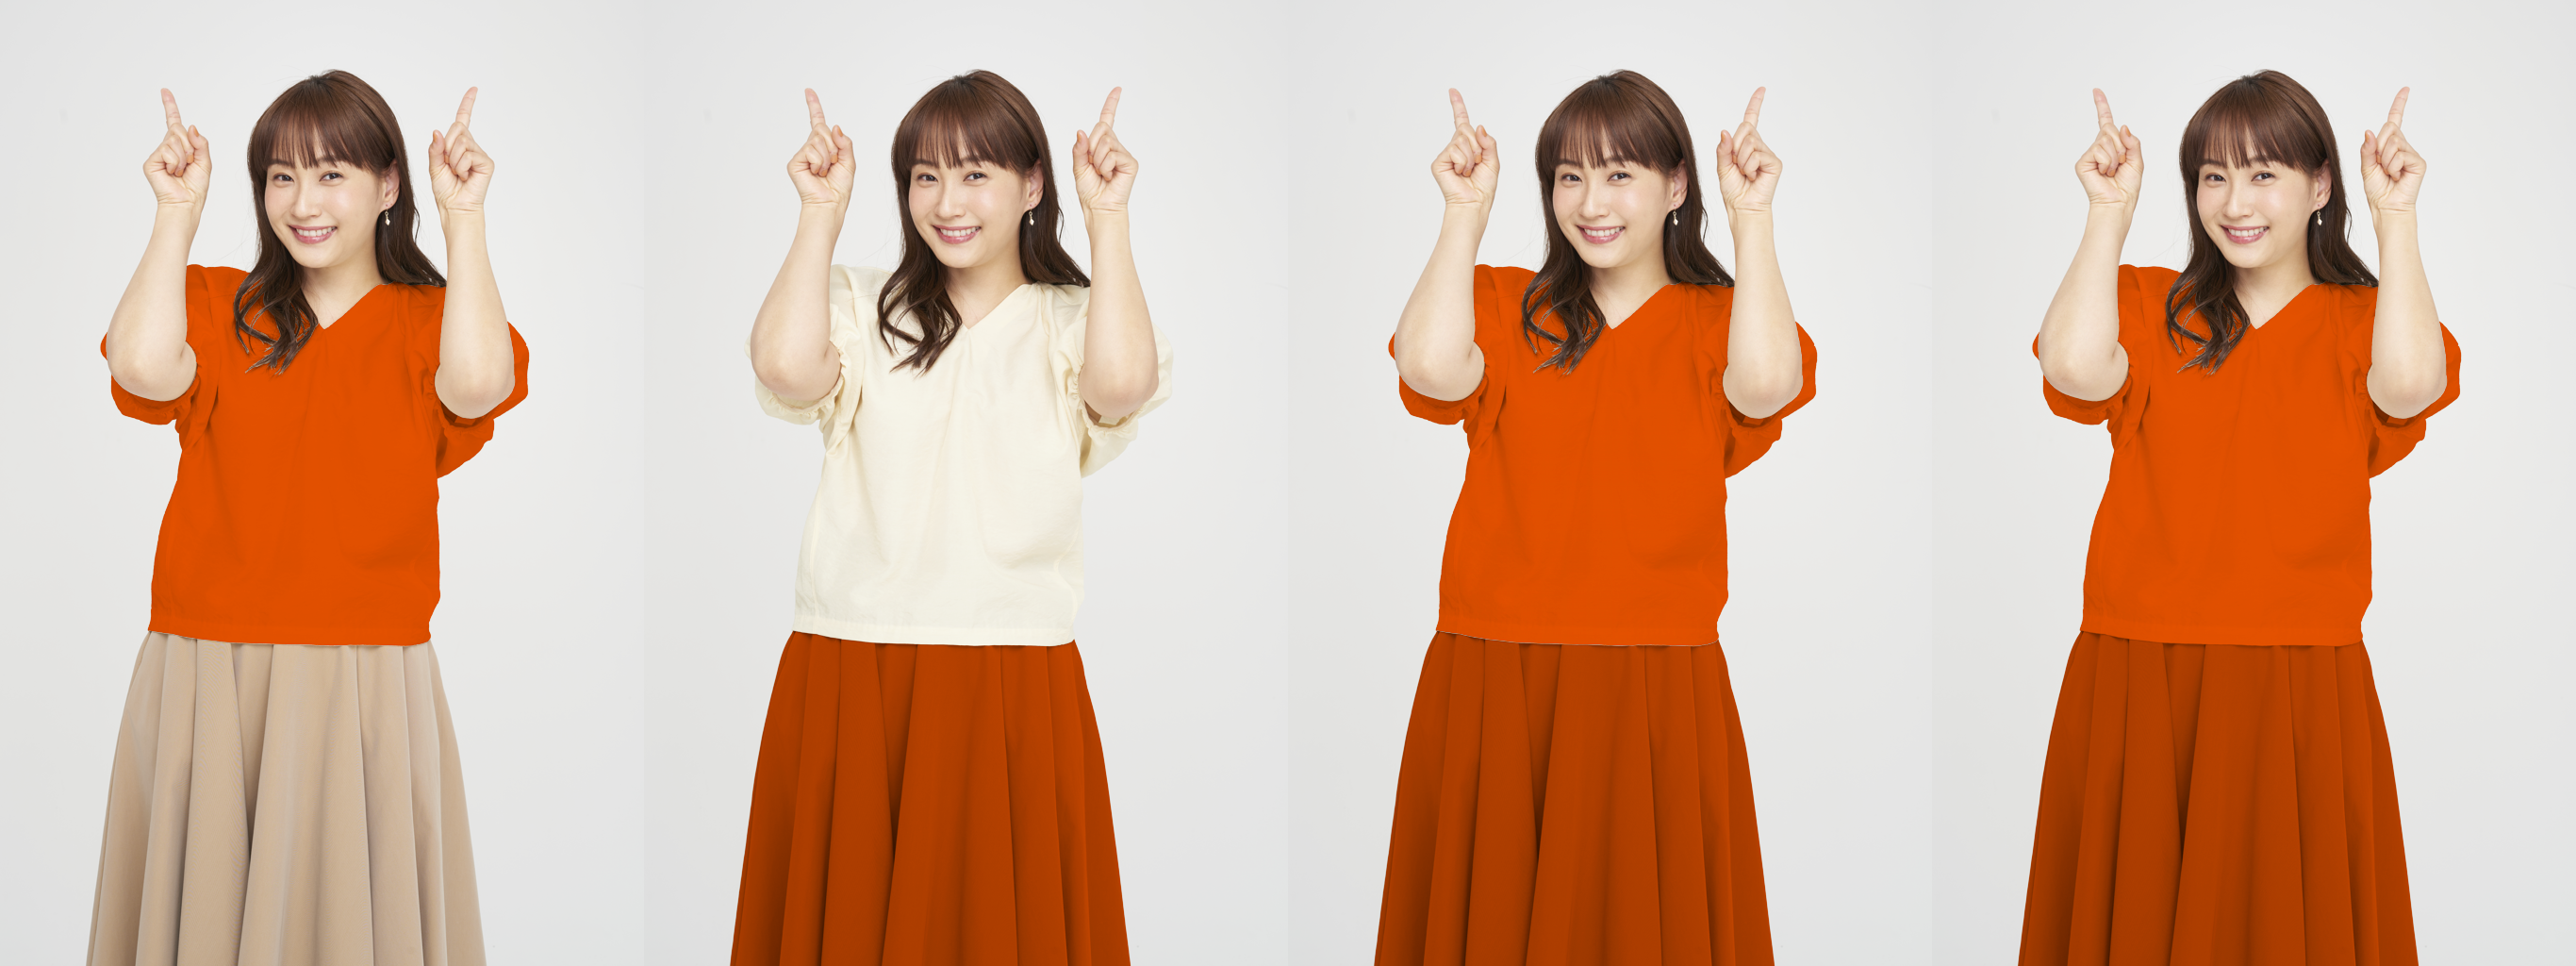

In [36]:

base_image_overlay_top = overlay_color_to_image('#ee5500', '#e9e9e9', base_image, top_mask_inverted)
base_image_overlay_top_preview, _ = preview_image(PreviewImage(base_image_overlay_top))[0]
base_image_overlay_bottom = overlay_color_to_image('#ee5500', '#e9e9e9', base_image, bottom_mask_inverted)
base_image_overlay_bottom_preview, _ = preview_image(PreviewImage(base_image_overlay_bottom))[0]
base_image_overlay_combined = overlay_color_to_image('#ee5500', '#e9e9e9', base_image_overlay_top, bottom_mask_inverted)
base_image_overlay_combined_preview, _ = preview_image(PreviewImage(base_image_overlay_combined))[0]
base_image_overlay_clothes = overlay_color_to_image('#ee5500', '#e9e9e9', base_image, clothes_mask_inverted)
base_image_overlay_clothes_preview, _ = preview_image(PreviewImage(base_image_overlay_clothes))[0]

image_grid([base_image_overlay_top_preview, base_image_overlay_bottom_preview, base_image_overlay_combined_preview, base_image_overlay_clothes_preview], 1, 4)